In [1]:
from quapack.pyRPE import RobustPhaseEstimation
from quapack.pyRPE.quantum import Q
import numpy as np
import pygsti#You may get a warning about Cython here; ignore it.
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
from pygsti.modelpacks import smq2Q_XYICPHASE

/Users/kmrudin/venvs/rpe/lib/python3.10/site-packages/pygsti/baseobjs/opcalc/__init__.py:31: UserWarning: 
An optimized Cython-based implementation of `pygsti.baseobjs.opcalc` is available as
an extension, but couldn't be imported. This might happen if the
extension has not been built. `pip install cython`, then reinstall
pyGSTi to build Cython extensions. Alternatively, setting the
environment variable `PYGSTI_NO_CYTHON_WARNING` will suppress this
message.

  _warnings.warn(warn_msg)
/Users/kmrudin/venvs/rpe/lib/python3.10/site-packages/pygsti/modelmembers/operations/lindbladcoefficients.py:22: UserWarning: Could not import cython module `fastcalc`. This may indicate that your cython extensions for pyGSTi failed to.properly build. Lack of cython extensions can result in significant performance degredation so we recommend trying to rebuild them.Falling back to numpy implementation for triu_indices.
  _warnings.warn(msg)
/Users/kmrudin/venvs/rpe/lib/python3.10/site-packages/pygsti/circu

# Overview
This notebook is supplemental material for arXiv:2502.06698 ("Heisenberg-limited calibration of entangling gates with robust phase estimation").  It demonstrates how to perform RPE using the pyRPE and pyGSTi packages.  (See README.txt for installation instructions.)

# Background
Let CZ$[\theta_{IZ},\theta_{ZI},\theta_{ZZ}] = e^{-\tfrac{i}{2}\left(-\tfrac{\pi}{2}II+\theta_{IZ}IZ + \theta_{ZI} ZI + \theta_{ZZ}ZZ\right)}$.

If $\theta_{IZ}=\theta_{ZI}=-\theta_{ZZ}=\tfrac{\pi}{2}$ then CZ$[\theta_{IZ},\theta_{ZI},\theta_{ZZ}]=\text{diag}[1,1,1,-1]=CZ$

The eigenvectors of CZ$[\theta_{IZ},\theta_{ZI},\theta_{ZZ}]$ are just $\{|00\rangle,|01\rangle,|10\rangle,|11\rangle\}$.

The corresponding eigenvalues are (up to global phase) are

$\lambda_{00}=e^{-\tfrac{i}{2}\left(\theta_{IZ}+\theta_{ZI}+\theta_{ZZ}\right)}$

$\lambda_{01}=e^{-\tfrac{i}{2}\left(-\theta_{IZ}+\theta_{ZI}-\theta_{ZZ}\right)}$

$\lambda_{10}=e^{-\tfrac{i}{2}\left(\theta_{IZ}-\theta_{ZI}-\theta_{ZZ}\right)}$

$\lambda_{11}=e^{-\tfrac{i}{2}\left(-\theta_{IZ}-\theta_{ZI}+\theta_{ZZ}\right)}$

Each eigenphase $\phi_{pq}$ is given by $\phi_{pq}=i\log{\lambda_{pq}}$, or:

$\phi_{00}=(\theta_{IZ}+\theta_{ZI}+\theta_{ZZ})/2$

$\phi_{01}=(-\theta_{IZ}+\theta_{ZI}-\theta_{ZZ})/2$

$\phi_{10}=(\theta_{IZ}-\theta_{ZI}-\theta_{ZZ})/2$

$\phi_{11}=(-\theta_{IZ}-\theta_{ZI}+\theta_{ZZ})/2$

We wish to learn $\theta_{IZ}$, $\theta_{ZI}$ and $\theta_{ZZ}$.  Via RPE we will learn relative phase differences (i.e., eigenphase differences) $\phi_{(pq,rs)}=\phi_{pq}-\phi_{rs}$ which will in turn allow us to learn $\theta_{IZ}$, $\theta_{ZI}$ and $\theta_{ZZ}$ by linear inversion. 

We choose to learn the following $\phi_{pq,rs}$ quantities:

$\phi_{(00,01)}=\theta_{IZ}+\theta_{ZZ}$

$\phi_{(10,11)}=\theta_{IZ}-\theta_{ZZ}$

$\phi_{(01,11)}=\theta_{ZI}-\theta_{ZZ}$


To describe the RPE circuits used for learning $\phi_{(pq,rs)}$ we first define the following states and observables:

$|\pm x_{(pq,rs)}\rangle:=\tfrac{1}{\sqrt{2}}\left(|pq\rangle\pm|rs\rangle\right)$

$|\pm y_{(pq,rs)}\rangle:=\tfrac{1}{\sqrt{2}}\left(|pq\rangle\pm i|rs\rangle\right)$

$I_{(pq,rs)} = |+x_{(pq,rs)}\rangle\langle+x_{(pq,rs)}| - |-x_{(pq,rs)}\rangle\langle-x_{(pq,rs)}|$ ("In-phase operator" or "cosine observable")


$Q_{(pq,rs)} = |+y_{(pq,rs)}\rangle\langle+y_{(pq,rs)}| - |-y_{(pq,rs)}\rangle\langle-y_{(pq,rs)}|$ ("Quadrature operator" or "sine observable")

We gather an RPE dataset for learning $\phi_{(pq,rs)}$ by estimating both $\langle I_{(pq,rs)} \rangle$ and $\langle Q_{(pq,rs)} \rangle$ given the input state $|+x_{(pq,rs)}\rangle$ followed by $k$ applications of the $CZ$ gate for $k\in[1,2,\ldots,k_\max]$.

We estimate each $\phi_{pq,rs}$ via RPE (here using the pyRPE software package) and in turn learn 
$\theta_{IZ}$, $\theta_{ZI}$, and $\theta_{ZZ}$ by linear inversion.

# Code

## Define relevant helper functions for generating quantum circuit lists and analyzing data.

In [2]:
#Define functions for generating the quantum circuits for estimating $I_{(pq,rs)}$ and $Q_{(pq,rs)}$:

def make_cos_circ(k,state_pair,line_labels=(0,1)):
    '''
    Generate circuit for RPE's in-phase/"cosine" measurement for the CZ gate.
    
    Parameters
    ----------
    k : integer
        The number of repetition of CZ.
    
    state_pair : tuple of 2-bit strings
        Which eigenstates are we learning the phase difference for.  
        Supported choices are ('00','01'), ('10','11'), ('01', 11)
    
    line_labels : tuple
        Labels for the qubits targeted by the CZ.  Useful if deployed on device with many qubits.
    
    Returns
    -------
    pygsti.circuits.Circuit
        A pygsti Circuit object corresponding to the requested RPE circuit.
    
    '''
    c, t = line_labels
    
    core_subcirc = pygsti.circuits.Circuit([[('Gcphase',c,t)]],line_labels=line_labels)*k

    #Circuit for sampling from 1/2 (1 + cos(k(theta_iz+theta_zz))):
    if state_pair == ('00','01'):
        prep_subcirc = pygsti.circuits.Circuit([[('Gypi2',t)]],line_labels=line_labels)#Prepare |00> + |01>
        meas_subcirc = pygsti.circuits.Circuit([[('Gypi2',t)]],line_labels=line_labels)#Map <00| ± <01| to Z basis

    #Circuit for sampling from 1/2 (1 + cos(k(theta_iz-theta_zz))):
    elif state_pair == ('10','11'):
        prep_subcirc = (pygsti.circuits.Circuit([[('Gxpi2',c)],
                                                 [('Gxpi2',c)],
                                                 [('Gypi2',t)]],line_labels=line_labels))#Prepare |10> + |11>
        meas_subcirc = pygsti.circuits.Circuit([[('Gypi2',t)]],line_labels=line_labels)#Map <10| ± <11| to Z basis 
    
    #Circuit for sampling from 1/2 (1 + cos(k(theta_zi-theta_zz))):
    elif state_pair == ('01','11'):
        prep_subcirc = (pygsti.circuits.Circuit([[('Gxpi2',t)],
                                                 [('Gxpi2',t)],
                                                 [('Gypi2',c)]],line_labels=line_labels))#Prepare |01> + |11>
        meas_subcirc = pygsti.circuits.Circuit([[('Gypi2',c)]],line_labels=line_labels)#Map <01| ± <11| to Z basis.
    else:
        assert False, "state_pair must be ('00','01'), ('10','11'), or ('01','11')."
    
    circ = prep_subcirc + core_subcirc + meas_subcirc
    
    return circ

    
def make_sin_circ(k,state_pair,line_labels=(0,1)):
    '''
    Generate circuit for RPE's quadrature/"sin" measurement for the CZ gate.
    
    Parameters
    ----------
    k : integer
        The number of repetition of CZ.
    
    state_pair : tuple of 2-bit strings
        Which eigenstates are we learning the phase difference for.  
        Supported choices are ('00','01'), ('10','11'), ('01', 11)
    
    line_labels : tuple
        Labels for the qubits targeted by the CZ.  Useful if deployed on device with many qubits.
    
    Returns
    -------
    pygsti.circuits.Circuit
        A pygsti Circuit object corresponding to the requested RPE circuit.
    
    '''

    c, t = line_labels

    core_subcirc = pygsti.circuits.Circuit([[('Gcphase',c,t)]],line_labels=line_labels)*k

    #Circuit for sampling from 1/2 (1 + sin(k(theta_iz+theta_zz))):    
    if state_pair == ('00','01'):
        prep_subcirc = pygsti.circuits.Circuit([[('Gypi2',t)]],line_labels=line_labels)#Prepare |00> + |01>
        meas_subcirc = pygsti.circuits.Circuit([[('Gxpi2',t)]],line_labels=line_labels)#Map <00| ±i <01| to Z basis

    #Circuit for sampling from 1/2 (1 + cos(k(theta_iz-theta_zz))):
    elif state_pair == ('10','11'):
        prep_subcirc = pygsti.circuits.Circuit([[('Gxpi2',c)],
                                                [('Gxpi2',c)],
                                                [('Gypi2',t)]],line_labels=line_labels)#Prepare |10> + |11>
        meas_subcirc = pygsti.circuits.Circuit([[('Gxpi2',t)]],line_labels=line_labels)#Map <10| ±i <11| to Z basis.
    
    
    elif state_pair == ('01','11'):
        prep_subcirc = pygsti.circuits.Circuit([[('Gxpi2',t)],
                                                [('Gxpi2',t)],
                                                [('Gypi2',c)]],line_labels=line_labels)#Prepare |01> + |11>
        meas_subcirc = pygsti.circuits.Circuit([[('Gxpi2',c)]],line_labels=line_labels)#Map <01| ±i <11| to Z basis.
    else:
        assert False, "('00','01'), ('10','11'), or ('01','11')"
    
    circ = prep_subcirc + core_subcirc + meas_subcirc
    
    return circ


In [3]:
#Each cosine (sine) RPE circuit has one outcome that increments the "+ outcome" count 
#and one that increments the "- outcome" count.  This dictionary explicitly tracks that information.
#If any other outcome is observed the shot is discarded.

state_pair_outcome_mapping = {('00','01'):{('cos','+'):'01', ('cos','-'):'00',
                                     ('sin','+'):'00', ('sin','-'):'01'},
                              ('10','11'):{('cos','+'):'11', ('cos','-'):'10',
                                     ('sin','+'):'10', ('sin','-'):'11'},
                              ('01','11'):{('cos','+'):'11', ('cos','-'):'01',
                                     ('sin','+'):'01', ('sin','-'):'11'}}
                

In [4]:
#Define the series of log-spaced repetitions of the CZ  gate.
#Can go shallower or deeper.  
#The deeper we can go, the better (up to depolarization).
max_depths = [1,2,4,8,16,32]

In [5]:
#List the eigenstate pairs we will be estimating the phase differences (\phi_{(pq,rs)}) for.
state_pairs = [('00','01'),('10','11'),('01','11')]

In [6]:
#Define the "line labels" for the experiment, i.e., the labels for the qubits that RPE will be run on.
exp_line_labels = (0,1)

In [7]:
#Construct the list of RPE circuits.

sin_dict = {state_pair: {i: make_sin_circ(i,state_pair,exp_line_labels) for i in max_depths} for state_pair in state_pairs}
cos_dict = {state_pair: {i: make_cos_circ(i,state_pair,exp_line_labels) for i in max_depths} for state_pair in state_pairs}

circ_dict = {'sin':sin_dict,'cos':cos_dict}

all_circs = []
for trig_dict in [sin_dict,cos_dict]:
    for state_pair in state_pairs:
        all_circs += list(trig_dict[state_pair].values())

all_circs = pygsti.remove_duplicates(all_circs)

In [8]:
#RPE by default estimates angles in [0,2pi].  
#theta_iz+theta_zz can be negative, however, which RPE then erroneously reports as theta_iz+theta_zz+2pi.
#We solve this problem via the rectify_angle function defined here.
def rectify_angle(theta):
    if theta > np.pi:
        theta -= 2*np.pi
    return theta


## Generate simulated data

In [9]:
#Define parameterized CZ for generating simulated data.
def CZ(theta_iz,theta_zi,theta_zz):#diag([1,1,1,-1]) == CZ(np.pi/2,np.pi/2,-np.pi/2) (up to phase)
    return scipy.linalg.expm(-1j / 2 * (theta_iz * pygsti.sigmaiz + theta_zi * pygsti.sigmazi + theta_zz * pygsti.sigmazz))

In [10]:
#Use built-in pyGSTi modelpack to define target and noisy gate sets.
target_model = smq2Q_XYICPHASE.target_model(qubit_labels=exp_line_labels)

In [11]:
target_theta_iz = np.pi/2
target_theta_zi = np.pi/2
target_theta_zz =-np.pi/2

In [12]:
#Define the rotation angles used for the simulated dataset
delta_theta_iz =  0.1
delta_theta_zi = -0.2
delta_theta_zz = -0.3

theta_iz = target_theta_iz + delta_theta_iz
theta_zi = target_theta_zi + delta_theta_zi
theta_zz = target_theta_zz + delta_theta_zz

noisy_model = target_model.copy()
noisy_model['Gcphase',exp_line_labels[0],exp_line_labels[1]] = pygsti.unitary_to_pauligate(
    CZ(theta_iz, theta_zi, theta_zz))

In [13]:
#What angles will we be trying to estimate?
print(f"Phase differences to estimate:")
print(f"('00','01') : (theta_iz+theta_zz) ={(theta_iz+theta_zz) : .4f}")
print(f"('10','11') : (theta_iz-theta_zz) ={(theta_iz-theta_zz) : .4f}")
print(f"('01','11') : (theta_zi-theta_zz) ={(theta_zi-theta_zz) : .4f}")
print()
print(f"Underlying parameters to estimate:")
print(f"theta_iz ={(theta_iz) : .4f}")
print(f"theta_zi ={(theta_zi) : .4f}")
print(f"theta_zz ={(theta_zz) : .4f}")

Phase differences to estimate:
('00','01') : (theta_iz+theta_zz) =-0.2000
('10','11') : (theta_iz-theta_zz) = 3.5416
('01','11') : (theta_zi-theta_zz) = 3.2416

Underlying parameters to estimate:
theta_iz = 1.6708
theta_zi = 1.3708
theta_zz =-1.8708


In [14]:
#Make an RPE dataset with the noisy model
N = 100#Number of repetitions per circuit
dataset_0 = pygsti.data.simulate_data(noisy_model,all_circs,N)

In [15]:
#To simulate loading in experimental data, we write the file to disk and then reload it.
#If there is actual experimental data present, it should populate the dataset file and then be loaded in.
pygsti.io.write_dataset('rpe_dataset_demo.txt',dataset_0)
dataset_1 = pygsti.io.read_dataset('rpe_dataset_demo.txt')

Reading rpe_dataset_demo.txt: 100%


In [16]:
#Post-process the RPE data from the pyGSTi dataset
the_experiments = {}
for state_pair in state_pairs:
    the_experiments[state_pair] = Q()

for state_pair in state_pairs:
    cos_plus = state_pair_outcome_mapping[state_pair]['cos','+']
    cos_minus = state_pair_outcome_mapping[state_pair]['cos','-']
    sin_plus = state_pair_outcome_mapping[state_pair]['sin','+']
    sin_minus = state_pair_outcome_mapping[state_pair]['sin','-']
    for i in max_depths:
        the_experiments[state_pair].process_sin(i,(int(dataset_1[sin_dict[state_pair][i]][sin_plus]),
                                                   int(dataset_1[sin_dict[state_pair][i]][sin_minus])))
        the_experiments[state_pair].process_cos(i,(int(dataset_1[cos_dict[state_pair][i]][cos_plus]),
                                                   int(dataset_1[cos_dict[state_pair][i]][cos_minus])))
        

In [17]:
#Analyze the RPE dataset.
analyses = {}
last_good_estimate_generations = {}

for state_pair in state_pairs:
    #Run RPE analysis
    analyses[state_pair] = RobustPhaseEstimation(the_experiments[state_pair])
    
    #Run consistency check analysis
    last_good_estimate_generations[state_pair] = analyses[(state_pair)].check_unif_local(historical=True)

    #Rectify estimates of $\phi_{(00,01)}$ that might be negative in reality but reported as larger than pi.
    #This step must be done *after* the consistency check analysis.
    if state_pair == ('00','01'):
        analyses[state_pair].angle_estimates = [rectify_angle(theta) for theta in analyses[state_pair].angle_estimates]#rectify_angle(analyses[state_pair].angle_estimates)

#Determine last trusted estimate generation.
last_good_estimate_generation = min(list(last_good_estimate_generations.values()))

print(f'Last good generation is generation {last_good_estimate_generation} (depth L={2**last_good_estimate_generation})')

Last good generation is generation 5 (depth L=32)


In [18]:
#Turn lin. comb. estimates into estimates of {theta_ij}.
theta_iz_estimates = 0.5*(np.array(analyses[('00','01')].angle_estimates) + np.array(analyses[('10','11')].angle_estimates))
theta_zz_estimates = 0.5*(np.array(analyses[('00','01')].angle_estimates) - np.array(analyses[('10','11')].angle_estimates))
theta_zi_estimates = np.array(analyses[('01','11')].angle_estimates)+theta_zz_estimates

angle_estimates = {'theta_iz':theta_iz_estimates,'theta_zi':theta_zi_estimates,'theta_zz':theta_zz_estimates}

In [19]:
#Reminder of phase differences and underlying parameters we're trying to estimate.
#(Can't know these without actually knowing true phases.)
print(f"Phase differences to estimate:")
print(f"('00','01') : (theta_iz+theta_zz) ={(theta_iz+theta_zz) : .4f}")
print(f"('10','11') : (theta_iz-theta_zz) ={(theta_iz-theta_zz) : .4f}")
print(f"('01','11') : (theta_zi-theta_zz) ={(theta_zi-theta_zz) : .4f}")
print()
print(f"Underlying parameters to estimate:")
print(f"theta_iz ={(theta_iz) : .4f}")
print(f"theta_zi ={(theta_zi) : .4f}")
print(f"theta_zz ={(theta_zz) : .4f}")

Phase differences to estimate:
('00','01') : (theta_iz+theta_zz) =-0.2000
('10','11') : (theta_iz-theta_zz) = 3.5416
('01','11') : (theta_zi-theta_zz) = 3.2416

Underlying parameters to estimate:
theta_iz = 1.6708
theta_zi = 1.3708
theta_zz =-1.8708


In [20]:
#What linear cominations of phases did we iteratively reconstruct?

angle_combination_labels = ['theta_iz+theta_zz','theta_iz-theta_zz','theta_zi-theta_zz']
angle_labels = ['theta_iz','theta_zi','theta_zz']


for idx, state_pair in enumerate(state_pairs):
    print(angle_combination_labels[idx])
    for phase_diff_est in analyses[state_pair].angle_estimates:
        print(f'{phase_diff_est : .4f}', end=' ')
    print('\n\n')

    
for angle_label in angle_labels:
#    , state_pair in enumerate(state_pairs):
    print(angle_label)
    for angle_est in angle_estimates[angle_label]: 
        print(f'{angle_est : .4f}', end=' ')
    print('\n\n')


theta_iz+theta_zz
-0.3520 -0.2318 -0.1858 -0.2038 -0.1976 -0.1951 


theta_iz-theta_zz
 3.6225  3.5343  3.5094  3.5293  3.5355  3.5442 


theta_zi-theta_zz
 3.4146  3.2901  3.2596  3.2433  3.2299  3.2441 


theta_iz
 1.6352  1.6512  1.6618  1.6627  1.6690  1.6745 


theta_zi
 1.4273  1.4071  1.4120  1.3768  1.3633  1.3745 


theta_zz
-1.9873 -1.8831 -1.8476 -1.8666 -1.8666 -1.8696 




(0.0005, np.float64(0.14659534532571666))

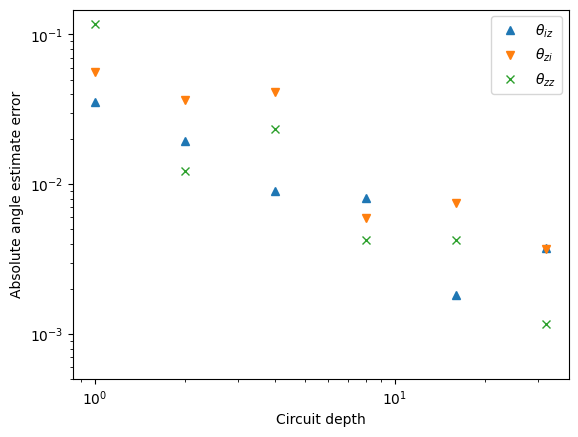

In [21]:
#Can plot accuracy of estimates when truth is known.  (Can't do this for experimental data.)
plt.plot(max_depths,np.abs(theta_iz - theta_iz_estimates),'^',label=r'$\theta_{iz}$')
plt.plot(max_depths,np.abs(theta_zi - theta_zi_estimates),'v',label=r'$\theta_{zi}$')
plt.plot(max_depths,np.abs(theta_zz - theta_zz_estimates),'x',label=r'$\theta_{zz}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Circuit depth')
plt.ylabel('Absolute angle estimate error')
plt.legend()
plt.ylim(bottom=5e-4)

In [22]:
#Now we use our last "trusted" RPE angle estimate (calculated earlier).  
#This is the quantity that will get fed to the optimizer.

print(f'RPE\'s best estimate of theta_iz is {theta_iz_estimates[last_good_estimate_generation]}')
print(f'RPE\'s best estimate of theta_zi is {theta_zi_estimates[last_good_estimate_generation]}')
print(f'RPE\'s best estimate of theta_zz is {theta_zz_estimates[last_good_estimate_generation]}')

RPE's best estimate of theta_iz is 1.6745272589252347
RPE's best estimate of theta_zi is 1.3744867063837949
RPE's best estimate of theta_zz is -1.869627465801994


In [23]:
print(f'Number to feed into optimizer is |theta_zz_estimate - theta_zz_target|={np.abs(target_theta_zz - theta_zz_estimates[last_good_estimate_generation])}')

Number to feed into optimizer is |theta_zz_estimate - theta_zz_target|=0.29883113900709746
